In [1]:
library(tidyverse)
library(openxlsx)
library(chisq.posthoc.test)
library(corrplot)
options(stringsAsFactors = F)
setwd("../../../../Fetal_metaQTL/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘openxlsx’ was built under R version 4.1.1”
corrplot 0.92 loaded



# Functions 

In [2]:
fisher_ORA <- function(test_set, test_background, ref_set, ref_background, verbose = FALSE) {
    overlap = length(intersect(test_set, ref_set)) #q
    group1 = length(intersect(test_set, ref_background)) #k
    group2 = length(intersect(ref_set, test_background)) #m
    total = length(intersect(test_background, ref_background)) #t
    
    mat <- matrix(c(
        overlap, group1,
        group2, total
    ), nrow=2)
    rownames(mat) <- c("inRef", "!inRef")
    colnames(mat) <- c("inTest", "!inTest")
    
    if (verbose) {
         print(mat)
    }
    
    fishers_df <- data.frame()
    fishers_df[1,1] <- overlap #q
    fishers_df[2,1] <- group2 - overlap #k-q
    fishers_df[1,2] <- group1 - overlap #m-q
    fishers_df[2,2] <- total - group2 - group1 + overlap #t-m-k+q

    res <- fisher.test(fishers_df, alternative='greater')
    return(res)
}

# Data Loading

In [3]:
readxl::excel_sheets("data/manuscript/ST1.xlsx")

[1] "README"                          "ST1-1-metadata"                 
[3] "ST1-2-eGene"                     "ST1-3-isoGene"                  
[5] "ST1-4-sGene"                     "ST1-5-torus-funcEnrich"         
[7] "ST1-6-conditional"               "ST1-7-fetalOnlyeGene-CellTypeEn"
[9] "ST1-8-inv-eQTL"

In [4]:
readxl::excel_sheets("data/manuscript/ST3.xlsx")

[1] "README"                       "ST3-1-tri1-eGene"            
[3] "ST3-2-tri2-eGene"             "ST3-3-tri1-isoGene"          
[5] "ST3-4-tri2-isoGene"           "ST3-5-tri1-sGene"            
[7] "ST3-6-tri2-sGene"             "ST3-7-triOnly-biotype"       
[9] "ST3-8-triOnly-cellTypeEnrich"

In [5]:
# Load in all discovered fetal eGenes
tableS1_2 <- readxl::read_xlsx("data/manuscript/ST1.xlsx", sheet="ST1-2-eGene")
fetal_all_eGenes <- tableS1_2 %>% select(pid) %>% pull()
length(fetal_all_eGenes)

[1] 10094

In [6]:
# Load in all discovered fetal sGenes
tableS1_4 <- readxl::read_xlsx("data/manuscript/ST1.xlsx", sheet="ST1-4-sGene")
fetal_all_sGenes <- tableS1_4 %>% select(group_id) %>% pull() %>% str_extract("ENSG[0-9]+")
length(fetal_all_sGenes)

[1] 8191

In [7]:
# Load eGenes
tr1_eGenes <- openxlsx::read.xlsx("data/manuscript/ST3.xlsx", sheet="ST3-1-tri1-eGene") %>% select(pid) %>% unique %>% pull
tr2_eGenes <- openxlsx::read.xlsx("data/manuscript/ST3.xlsx", sheet="ST3-2-tri2-eGene") %>% select(pid) %>% unique %>% pull

# Load sGenes
tr1_sGenes <- openxlsx::read.xlsx("data/manuscript/ST3.xlsx", sheet="ST3-5-tri1-sGene") %>% select(ensg) %>% unique %>% pull
tr2_sGenes <- openxlsx::read.xlsx("data/manuscript/ST3.xlsx", sheet="ST3-6-tri2-sGene") %>% select(ensg) %>% unique %>% pull

length(tr1_eGenes)
length(tr2_eGenes)

length(tr1_sGenes)
length(tr2_sGenes)

[1] 4211

[1] 2220

[1] 5313

[1] 2319

In [8]:
# Define a not-in operator for simplicity
`%notin%` <- Negate(`%in%`)

# Filter to trimester-specific eGenes
tri1_only_eGenes <- tr1_eGenes[tr1_eGenes %notin% tr2_eGenes]
length(tri1_only_eGenes)

tri2_only_eGenes <- tr2_eGenes[tr2_eGenes %notin% tr1_eGenes]
length(tri2_only_eGenes)

tri12_eGene_bg <- unique(c(tr1_eGenes, tr2_eGenes))#, fetal_all_eGenes))
length(tri12_eGene_bg)

[1] 2950

[1] 959

[1] 5170

In [9]:
# Filter to trimester-specific sGenes
tri1_only_sGenes <- tr1_sGenes[tr1_sGenes %notin% tr2_sGenes]
length(tri1_only_sGenes)

tri2_only_sGenes <- tr2_sGenes[tr2_sGenes %notin% tr1_sGenes]
length(tri2_only_sGenes)

tri12_sGene_bg <- unique(c(tr1_sGenes, tr2_sGenes))#, fetal_all_sGenes))
length(tri12_sGene_bg)

[1] 3550

[1] 556

[1] 5869

In [10]:
# Load a gencode annotation for biotype parsing
gencode_annot <- read_tsv("data/accessory_files/gencode.v33lift37.annotation.gene.info.tsv")
head(gencode_annot, 3)

Rows: 62486 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): V1, V2, V3, V6, V7, V8, V9, ensg, version, V11, V12
dbl  (2): V4, V5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


V1,V2,V3,V4,V5,V6,V7,V8,V9,ensg,version,V11,V12
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,HAVANA,gene,11869,14409,.,+,.,"gene_id ""ENSG00000223972.5_2""; gene_type ""transcribed_unprocessed_pseudogene""; gene_name ""DDX11L1""; level 2; hgnc_id ""HGNC:37102""; havana_gene ""OTTHUMG00000000961.2_2""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000223972,5_2,transcribed_unprocessed_pseudogene,DDX11L1
chr1,HAVANA,gene,14404,29570,.,-,.,"gene_id ""ENSG00000227232.5_3""; gene_type ""unprocessed_pseudogene""; gene_name ""WASH7P""; level 2; hgnc_id ""HGNC:38034""; havana_gene ""OTTHUMG00000000958.1_3""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000227232,5_3,unprocessed_pseudogene,WASH7P
chr1,HAVANA,gene,29554,31109,.,+,.,"gene_id ""ENSG00000243485.5_6""; gene_type ""lncRNA""; gene_name ""MIR1302-2HG""; level 2; hgnc_id ""HGNC:52482""; tag ""ncRNA_host""; havana_gene ""OTTHUMG00000000959.2_6""; remap_status ""full_contig""; remap_num_mappings 1; remap_target_status ""overlap"";",ENSG00000243485,5_6,lncRNA,MIR1302-2HG


In [11]:
# Load cell type markers from fetal brain scRNAseq
# Poliodakis et al. cluster analysis (Table S4)
celltypemarkers_tableS4 <- openxlsx::read.xlsx('https://www.cell.com/cms/10.1016/j.neuron.2019.06.011/attachment/508ae008-b926-487a-b871-844a12acc1f8/mmc5.xlsx', sheet='Cluster enriched genes') %>% as_tibble()
celltypemarkers_tableS4 <- janitor::clean_names(celltypemarkers_tableS4)
celltypemarkers_tableS4_bg <- unique(celltypemarkers_tableS4$ensembl)

# Combine ExM and ExM-U
celltypemarkers_tableS4 <- celltypemarkers_tableS4 %>%
                                mutate(cluster = if_else(cluster == "ExM-U", "ExM", cluster))

head(celltypemarkers_tableS4)
dim(celltypemarkers_tableS4)
unique(celltypemarkers_tableS4$cluster)
length(celltypemarkers_tableS4_bg)

ensembl,gene,cluster,log2_fold_change,p_value,fdr,percent_expressed_cluster,percent_expressed_all_cells
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000171617,ENC1,ExN,1.15415684851705,0,0,73.3,55.2
ENSG00000124766,SOX4,ExN,0.829387981626601,0,0,88.1,80.1
ENSG00000134138,MEIS2,ExN,0.81900483848292,0,0,63.5,52.2
ENSG00000164600,NEUROD6,ExN,0.816925751244978,0,0,72.1,59.7
ENSG00000155926,SLA,ExN,0.735309292588594,0,0,63.9,52.5
ENSG00000092820,EZR,ExN,0.715137175304713,0,0,58.8,48.5


[1] 7271    8

[1] "ExN"   "PgG2M" "OPC"   "End"   "ExDp2" "Per"   "Mic"   "ExM"   "IP"   
[10] "ExDp1" "InMGE" "InCGE" "oRG"   "PgS"   "vRG"

[1] 3870

# Analysis

## eGene Biotype Enrichment by Trimester

In [12]:
tr1_only_eGenes_biotypes <- gencode_annot %>% filter(ensg %in% tri1_only_eGenes)
tr2_only_eGenes_biotypes <- gencode_annot %>% filter(ensg %in% tri2_only_eGenes)

eGenes_biotype_df <- inner_join(tr1_only_eGenes_biotypes %>% count(V11) %>% rename("biotype" = "V11", "TR1_eGenes" = "n"),
                                tr2_only_eGenes_biotypes %>% count(V11) %>% rename("biotype" = "V11", "TR2_eGenes" = "n"), by = "biotype") %>%
                          column_to_rownames("biotype") %>%
                          filter(TR1_eGenes > 5 & TR2_eGenes > 5)

eGenes_biotype_df

,TR1_eGenes,TR2_eGenes
,<int>,<int>
lncRNA,808,246
miRNA,134,15
misc_RNA,79,15
processed_pseudogene,99,37
protein_coding,1508,574
snoRNA,47,8
TEC,56,17
transcribed_processed_pseudogene,28,7
transcribed_unprocessed_pseudogene,75,19


In [13]:
# Chi-square comparing counts of each biotype across trimesters
eGenes_chisq <- chisq.test(eGenes_biotype_df)
eGenes_chisq

# Post-hoc analysis to identify main drivers of the significant chi-square
posthoc <- chisq.posthoc.test(eGenes_biotype_df, method = "bonferroni")
posthoc_p_df <- posthoc %>% filter(Value == "p values") %>% select(c(3,4))
rownames(posthoc_p_df) <- (posthoc %>% filter(Value == "p values"))$Dimension
posthoc_p_df


	Pearson's Chi-squared test

data:  eGenes_biotype_df
X-squared = 37.109, df = 9, p-value = 2.517e-05


,TR1_eGenes,TR2_eGenes
,<dbl>,<dbl>
lncRNA,1.000000,1.000000
miRNA,0.000436,0.000436
misc_RNA,0.892418,0.892418
processed_pseudogene,1.000000,1.000000
protein_coding,0.000268,0.000268
snoRNA,1.000000,1.000000
TEC,1.000000,1.000000
transcribed_processed_pseudogene,1.000000,1.000000
transcribed_unprocessed_pseudogene,1.000000,1.000000


## sGene Biotype Enrichment by Trimester

In [14]:
tr1_only_sGenes_biotypes <- gencode_annot %>% filter(ensg %in% tri1_only_sGenes)
tr2_only_sGenes_biotypes <- gencode_annot %>% filter(ensg %in% tri2_only_sGenes)

sGenes_biotype_df <- inner_join(tr1_only_sGenes_biotypes %>% count(V11) %>% rename("biotype" = "V11", "TR1_sGenes" = "n"),
                                tr2_only_sGenes_biotypes %>% count(V11) %>% rename("biotype" = "V11", "TR2_sGenes" = "n"), by = "biotype") %>%
                          column_to_rownames("biotype") %>%
                          filter(TR1_sGenes > 5 & TR2_sGenes > 5)

sGenes_biotype_df

,TR1_sGenes,TR2_sGenes
,<int>,<int>
lncRNA,336,40
protein_coding,3120,511


In [15]:
# Chi-square is not significant, so not post-hoc testing
sGenes_chisq <- chisq.test(sGenes_biotype_df)
sGenes_chisq


	Pearson's Chi-squared test with Yates' continuity correction

data:  sGenes_biotype_df
X-squared = 3.1062, df = 1, p-value = 0.078


## eGene Cell Type Enrichment by Trimester

In [16]:
eGenes_cell_cluster_res <- tibble()

for (cell in unique(celltypemarkers_tableS4$cluster)) {
    cat(paste0(cell, " "))
    
    one_cell_markers <- celltypemarkers_tableS4 %>%
                            filter(cluster == cell) %>%
                            select(ensembl) %>%
                            pull
    
    res <- fisher_ORA(test_set = tri1_only_eGenes,
                       test_background = tri12_eGene_bg,
                       ref_set = one_cell_markers,
                       ref_background = celltypemarkers_tableS4_bg)
    
    eGenes_cell_cluster_res <- rbind(eGenes_cell_cluster_res, tibble(scenario = "tr1_only_eGenes",
                                                                       cell_type = cell,
                                                                       fisher_p = res$p.value,
                                                                       fisher_or = as.numeric(res$estimate)))
    
    res <- fisher_ORA(test_set = tri2_only_eGenes,
                       test_background = tri12_eGene_bg,
                       ref_set = one_cell_markers,
                       ref_background = celltypemarkers_tableS4_bg)
    
    eGenes_cell_cluster_res <- rbind(eGenes_cell_cluster_res, tibble(scenario = "tr2_only_eGenes",
                                                                       cell_type = cell,
                                                                       fisher_p = res$p.value,
                                                                       fisher_or = as.numeric(res$estimate)))
}

eGenes_cell_cluster_res %>% arrange(fisher_p)

ExN PgG2M OPC End ExDp2 Per Mic ExM IP ExDp1 InMGE InCGE oRG PgS vRG 

scenario,cell_type,fisher_p,fisher_or
<chr>,<chr>,<dbl>,<dbl>
tr2_only_eGenes,IP,0.002043758,3.4193856
tr1_only_eGenes,ExM,0.011352955,2.4244701
tr2_only_eGenes,OPC,0.098160753,1.5028491
tr1_only_eGenes,End,0.104472624,1.4687096
tr2_only_eGenes,ExN,0.120827541,2.5818938
tr2_only_eGenes,InMGE,0.273576596,1.4999255
tr2_only_eGenes,oRG,0.289440151,1.2027926
tr1_only_eGenes,Mic,0.291126764,1.1760123
tr1_only_eGenes,ExDp1,0.330540924,1.1821982


## sGene Cell Type Enrichment by Trimester

In [17]:
sGenes_cell_cluster_res <- tibble()

# If you combine ExM and ExM-U, you see an ExM signal whereas before the signal was too split
celltypemarkers_tableS4 <- celltypemarkers_tableS4 %>% mutate(cluster = if_else(cluster == "ExM-U", "ExM", cluster))

for (cell in unique(celltypemarkers_tableS4$cluster)) {
    cat(paste0(cell, " "))
    
    one_cell_markers <- celltypemarkers_tableS4 %>%
                            filter(cluster == cell) %>%
                            select(ensembl) %>%
                            pull
    
    res <- fisher_ORA(test_set = tri1_only_sGenes,
                       test_background = tri12_sGene_bg,
                       ref_set = one_cell_markers,
                       ref_background = celltypemarkers_tableS4_bg)
    
    sGenes_cell_cluster_res <- rbind(sGenes_cell_cluster_res, tibble(scenario = "tr1_only_sGenes",
                                                                       cell_type = cell,
                                                                       fisher_p = res$p.value,
                                                                       fisher_or = as.numeric(res$estimate)))
    
    res <- fisher_ORA(test_set = tri2_only_sGenes,
                       test_background = tri12_sGene_bg,
                       ref_set = one_cell_markers,
                       ref_background = celltypemarkers_tableS4_bg)
    
    sGenes_cell_cluster_res <- rbind(sGenes_cell_cluster_res, tibble(scenario = "tr2_only_sGenes",
                                                                       cell_type = cell,
                                                                       fisher_p = res$p.value,
                                                                       fisher_or = as.numeric(res$estimate)))
}

sGenes_cell_cluster_res %>% arrange(fisher_p)

ExN PgG2M OPC End ExDp2 Per Mic ExM IP ExDp1 InMGE InCGE oRG PgS vRG 

scenario,cell_type,fisher_p,fisher_or
<chr>,<chr>,<dbl>,<dbl>
tr2_only_sGenes,ExM,0.0006491774,2.2686080
tr2_only_sGenes,ExDp1,0.0218876692,1.5903059
tr1_only_sGenes,Per,0.0778561844,1.2321091
tr2_only_sGenes,oRG,0.1099259608,1.3565603
tr1_only_sGenes,PgG2M,0.1517904255,1.2180884
tr1_only_sGenes,End,0.1576608377,1.1875612
tr2_only_sGenes,End,0.1810103496,1.2539271
tr2_only_sGenes,Mic,0.1956987771,1.2271687
tr1_only_sGenes,Mic,0.2124872950,1.1409465


# Manuscript Figures

## Figure 3 - eGene and sGene Biotype Enrichment

In [18]:
eGenes_biotype_plot_df <- sweep(eGenes_biotype_df, 2, colSums(eGenes_biotype_df),`/`)
rownames(eGenes_biotype_plot_df) <- gsub("_", "\n", rownames(eGenes_biotype_plot_df))

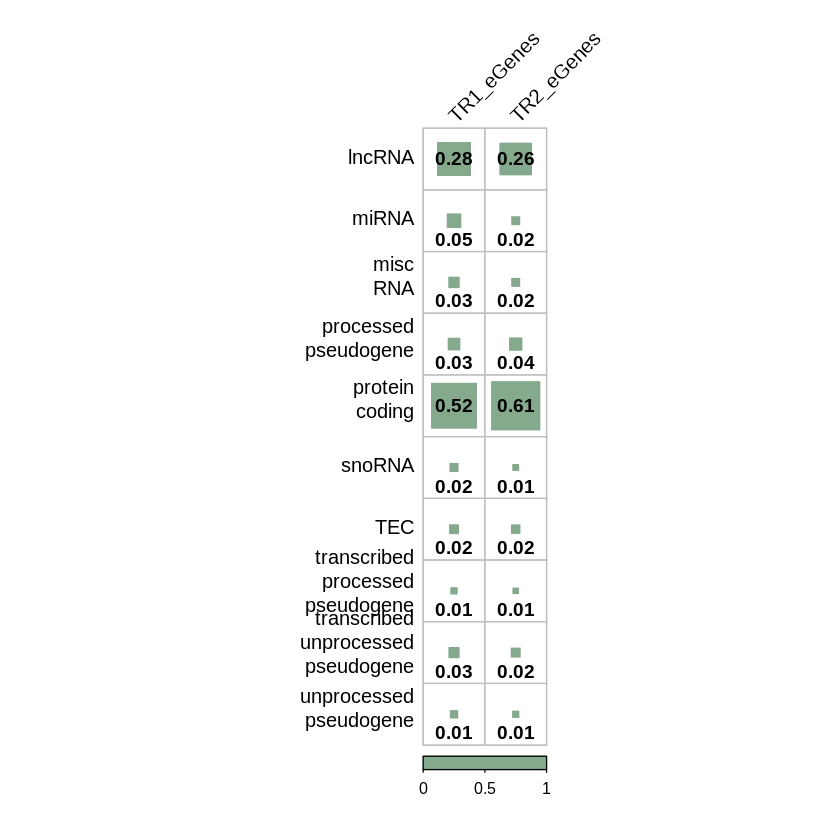

In [19]:
p1 <- corrplot::corrplot(as.matrix(eGenes_biotype_plot_df), method = 'square', is.cor = FALSE,
            mar=c(1,1,1,1), family = "Helvetica",
            cl.ratio = 0.1, cl.pos = 'b', cl.length = 3,
            tl.col = 'black', tl.srt = 45,
            col = "#84A98C", col.lim=c(0, 1))$corrPos
p1$corr <- c(as.matrix(eGenes_biotype_plot_df))
labels <- round(p1$corr, 2)
spacer <- 0.3
text(p1$x, p1$y-c(0, spacer, spacer, spacer, 0, spacer, spacer, spacer, spacer, spacer), labels, cex = 0.95, font = 2, family = "Helvetica")

In [20]:
sGenes_biotype_plot_df <- merge(eGenes_biotype_df %>% as.data.frame %>% rownames_to_column("biotype"),
                                sGenes_biotype_df %>% as.data.frame %>% rownames_to_column("biotype"), all = T)
sGenes_biotype_plot_df[is.na(sGenes_biotype_plot_df)] <- 0
sGenes_biotype_plot_df <- sGenes_biotype_plot_df %>% column_to_rownames("biotype") %>% select(contains("sGene"))
sGenes_biotype_plot_df <- sweep(sGenes_biotype_plot_df, 2, colSums(sGenes_biotype_df),`/`)
rownames(sGenes_biotype_plot_df) <- gsub("_", "\n", rownames(sGenes_biotype_plot_df))

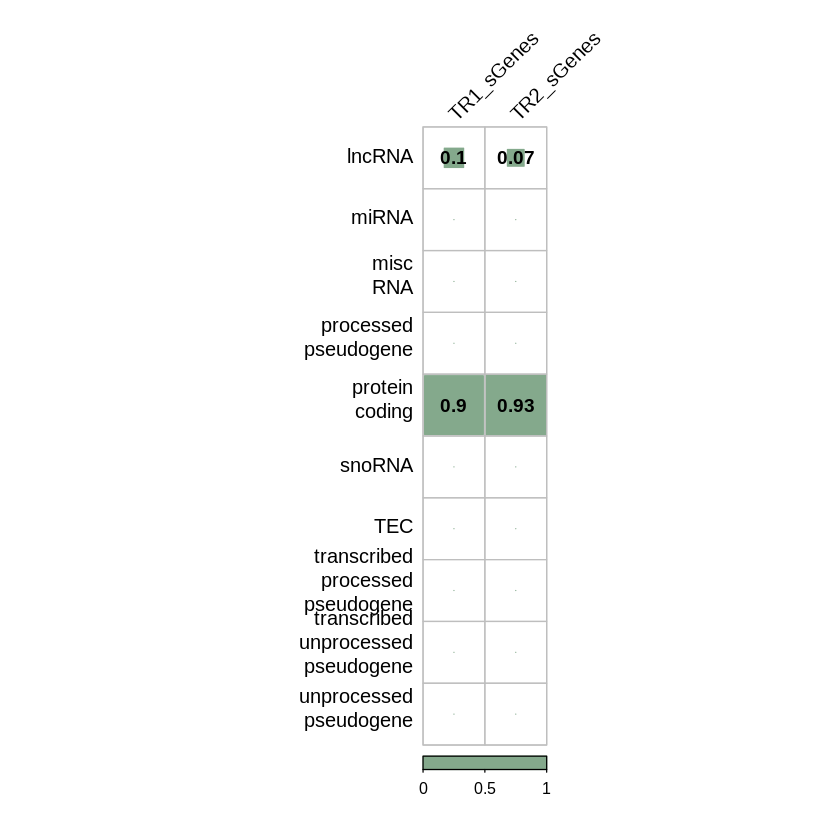

In [21]:
p2 <- corrplot::corrplot(as.matrix(sGenes_biotype_plot_df), method = 'square', is.cor = FALSE,
            mar=c(1,1,1,1), family = "Helvetica",
            cl.ratio = 0.1, cl.pos = 'b', cl.length = 3,
            tl.col = 'black', tl.srt = 45,
            col = "#84A98C", col.lim=c(0, 1))$corrPos
p2$corr <- c(as.matrix(sGenes_biotype_plot_df))
labels <- round(p2$corr, 2)
labels[labels < 0.05] <- ''
spacer <- 0.3
text(p2$x, p2$y, labels, cex = 0.95, font = 2, family = "Helvetica")

## Figure 3 - eGene and sGene Cell Type Enrichment

In [22]:
eGenes_plot_tbl <- eGenes_cell_cluster_res %>%
                    mutate(fisher_fdr = p.adjust(fisher_p, "fdr")) %>%
                    mutate(fisher_fdr_log = -log10(fisher_fdr)) %>%
                    arrange(cell_type) %>%
                    pivot_wider(id_cols = cell_type,
                                names_from = scenario,
                                values_from = fisher_fdr_log) %>%
                    column_to_rownames("cell_type")

Warning message in corrplot::corrplot(as.matrix(eGenes_plot_tbl), method = "square", :
“col.lim interval too wide, please set a suitable value”


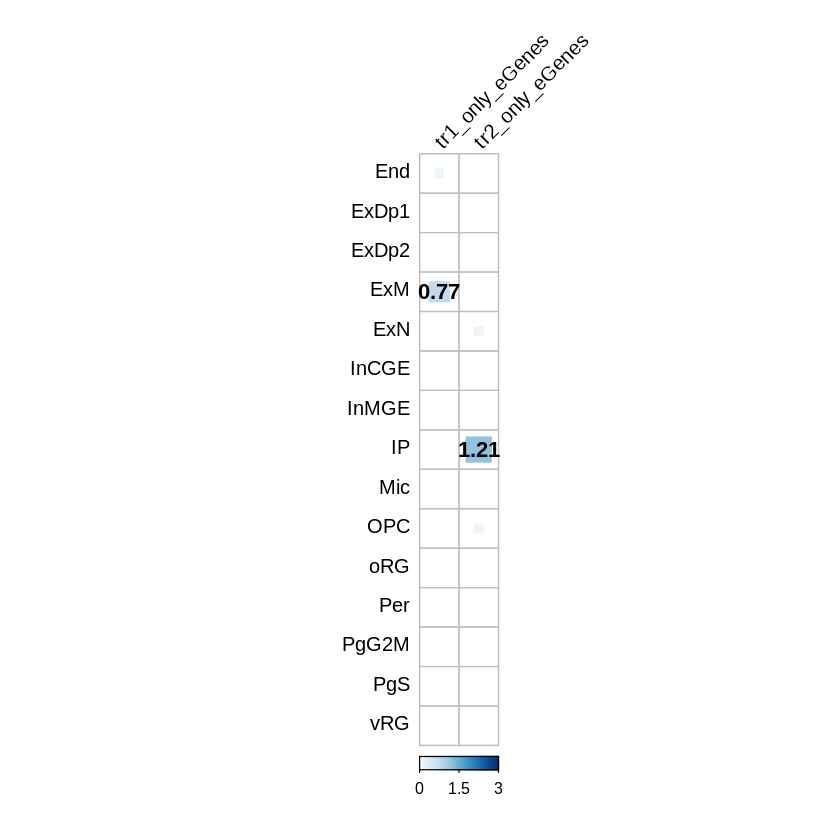

In [23]:
p3 <- corrplot::corrplot(as.matrix(eGenes_plot_tbl), method = 'square', is.cor = FALSE,
            mar=c(1,1,1,1), family = "Helvetica",
            cl.ratio = 0.1, cl.pos = 'b', cl.length = 3,
            tl.col = 'black', tl.srt = 45,
            col = corrplot::COL1('Blues', 200), col.lim=c(0, 3))$corrPos
p3$corr <- c(as.matrix(eGenes_plot_tbl))
labels <- round(p3$corr, 2)
labels[labels < 0.2] <- ''
text(p3$x, p3$y, labels, cex = 1.1, font = 2, family = "Helvetica")

In [24]:
sGenes_plot_tbl <- sGenes_cell_cluster_res %>%
                    mutate(fisher_fdr = p.adjust(fisher_p, "fdr")) %>%
                    mutate(fisher_fdr_log = -log10(fisher_fdr)) %>%
                    arrange(cell_type) %>%
                    pivot_wider(id_cols = cell_type,
                                names_from = scenario,
                                values_from = fisher_fdr_log) %>%
                    column_to_rownames("cell_type")

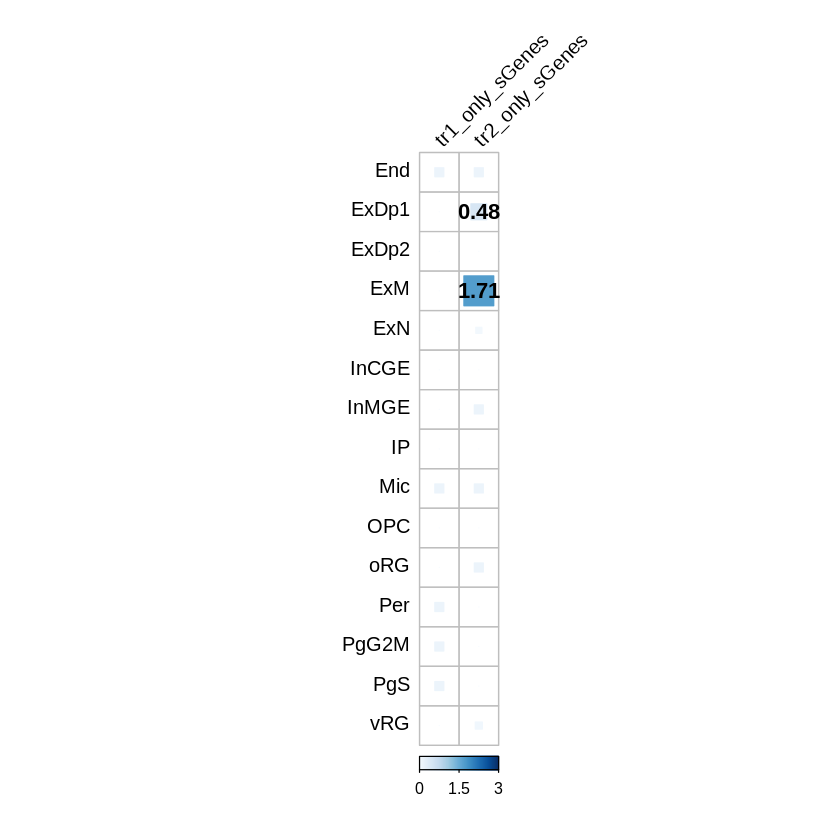

In [25]:
p4 <- corrplot::corrplot(as.matrix(sGenes_plot_tbl), method = 'square', is.cor = FALSE,
            mar=c(1,1,1,1), family = "Helvetica",
            cl.ratio = 0.1, cl.pos = 'b', cl.length = 3,
            tl.col = 'black', tl.srt = 45,
            col = corrplot::COL1('Blues', 200), col.lim=c(0, 3))$corrPos
p4$corr <- c(as.matrix(sGenes_plot_tbl))
labels <- round(p4$corr, 2)
labels[labels < 0.2] <- ''
text(p4$x, p4$y, labels, cex = 1.1, font = 2, family = "Helvetica")